# Analsysing influence of traffic incident.

### Section list:

<a href='#1'>1.Select all the links which near within expected zone of influence of sertain incidents</a>

<a href='#2'>2.Get normal day statistics for all the slected links()</a>

<a href='#3'>3.Get incident period statistics</a>

<a href='#4'>4.Get the deviations</a>

<a href='#5'>5.Define severity Level</a>

<a href='#6'>6.Visualization</a>

*** 
## 1.Select all the links which near within expected zone of influence of certain incidents
<a id='1'></a>

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

from scipy import spatial
import statistics
from sklearn.neighbors import KDTree


from geopy import distance
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import timedelta
#import date as td
import re 
import os

In [2]:
df_traffic_network=pd.read_csv('../../data/traffic_network.csv', dtype = {'btlinkid': str})
df_incident=pd.read_csv('../../data/incident_jul_aug_sep.csv')

df_traffic_network=gpd.read_file("../../Shapefile/BCC_TMR.shp")

df_incident.drop_duplicates(inplace=True) #delete duplicates
#select travel time data.
df_tt_jul=pd.read_csv('../../data/tt_jul.csv',index_col=0,dtype = {'btlinkid': str})
df_tt_aug=pd.read_csv('../../data/tt_aug.csv',index_col=0,dtype = {'btlinkid': str})
df_tt_sep=pd.read_csv('../../data/tt_sep.csv',index_col=0,dtype = {'btlinkid': str})
df_longtraffic_network=pd.read_csv('../../data/df_longtraffic_network.csv')

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
df_traffic_network.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 806 entries, 0 to 805
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   length      806 non-null    float64 
 1   datasource  806 non-null    object  
 2   name        806 non-null    object  
 3   btlinkid    806 non-null    object  
 4   Speed       805 non-null    float64 
 5   geometry    806 non-null    geometry
dtypes: float64(2), geometry(1), object(3)
memory usage: 37.9+ KB


In [4]:
df_traffic_network1=pd.read_csv('../../data/traffic_network.csv', dtype = {'btlinkid': str})


In [5]:
df_traffic_network[df_traffic_network.datasource=='bcc']

,length,datasource,name,btlinkid,Speed,geometry
0,1.594620,bcc,Mains Road( School Zone),1048410491,60.0,"LINESTRING (153.06397 -27.57199, 153.06389 -27..."
1,1.443722,bcc,McCullough Street,1048410494,60.0,"LINESTRING (153.06397 -27.57198, 153.06365 -27..."
2,0.680498,bcc,Mains Road,1048410538,60.0,"LINESTRING (153.06400 -27.57183, 153.06400 -27..."
3,1.042233,bcc,McCullough Road,1048410576,60.0,"LINESTRING (153.06425 -27.57186, 153.06454 -27..."
4,1.602083,bcc,Mains Road( School Zone),1049110484,60.0,"LINESTRING (153.06089 -27.58780, 153.06131 -27..."
...,...,...,...,...,...,...
513,1.034406,bcc,Railway Parade,1018910158,60.0,"LINESTRING (153.04782 -27.36936, 153.04691 -27..."
514,1.763428,bcc,Zillimere Road,1013318016,60.0,"LINESTRING (153.03823 -27.35947, 153.04065 -27..."
515,1.024862,bcc,Robinson Road west,1015810239,60.0,"LINESTRING (153.03687 -27.36683, 153.03748 -27..."
516,1.012337,bcc,Robinson Road west,1023910158,60.0,"LINESTRING (153.04803 -27.36826, 153.04781 -27..."


In [6]:
# merging two tt time data.
df_tt=df_tt_jul.append(df_tt_aug,ignore_index=True).append(df_tt_sep,ignore_index=True)

***

### Selected incidents
I have selected incident with following three incidents for analyse

### Actual selected incidents.

### Find nearest links of incidents

In [7]:
def convert_incident_time():
    df_incident['Time_Logged']=df_incident['Time_Logged'].astype('datetime64[ns]')
    df_incident['StartDetected_Time']=df_incident['StartDetected_Time'].astype('datetime64[ns]')
    df_incident['End_Time']=df_incident['End_Time'].astype('datetime64[ns]')
    #df_incident['Duration']=df_incident['End_Time']-df_incident['StartDetected_Time']

In [8]:
# the method
def create_KDtree(longlist):
    location=list(zip(longlist.Longitude, longlist.Latitude))
    return spatial.KDTree(location)
tree = create_KDtree(df_longtraffic_network)

In [9]:
def find_nearest_link(tr,longlist,Long,Lat,knumber): # the function requires KDtree object and X
    t_result=tr.query([Long,Lat],k=knumber) 
    #print(knumber)
    if knumber==1:
        df_result=pd.DataFrame({'distance':t_result[0],
                                'btlinkid':[longlist.iloc[t_result[1]].btlinkid]})
    else:
        df_result=pd.DataFrame({'distance':t_result[0],
                                'btlinkid':longlist.iloc[t_result[1]].btlinkid})
    return df_result

In [10]:
def level_0(incident_id):
    # Create empty dataframe()
    df_incident_link_0 = pd.DataFrame(columns=['incident_id','btlinkid','level'])
    
    for row in df_incident[df_incident.Identifier.isin(incident_id)].itertuples():
        result=find_nearest_link(tree,df_longtraffic_network,row.X,row.Y,1)# only one nearest
        if result.iloc[0].distance<=0.001:       
            new_row = { 'incident_id':row.Identifier,
                        'btlinkid':str(int(result.iloc[0].btlinkid)),
                        'level':0}
            df_incident_link_0=df_incident_link_0.append(new_row,ignore_index=True)
    return df_incident_link_0
    

In [11]:
## finding links based on radius distance
def calc_dist(center_point,longlist,d_range):
    temp_df=pd.DataFrame()
    
    for row in longlist.itertuples():
        #print((row.Latitude,row.Longitude))
        test_point_tuple = (row.Latitude,row.Longitude)
        dis = distance.distance(center_point_tuple,test_point_tuple).km
       
        if dis<= d_range:
            new_row = { 
                    'btlinkid':str(row.btlinkid),
                    'distace':dis
                     }
            temp_df=temp_df.append(new_row,ignore_index=True)
    return temp_df.btlinkid.unique()

In [12]:
def add_link(level_0,link_list):
    for row in link_list:
        level_0=level_0.append({'btlinkid':row,
                       'incident_id':level_0.iloc[0].incident_id
                       ,'level':1},ignore_index=True)
    return level_0

In [13]:
def day_clean():
    df_inc_1_tt=df_tt[df_tt.btlinkid.isin(df_incident_link_2.btlinkid)]

    df_inc_1_tt=df_inc_1_tt[df_inc_1_tt.Time_hr!=24] # clearing NA values in time series 
    #df_inc_1_tt=df_inc_1_tt.drop(columns=['Unnamed: 0']) #deleted unecesarry columns

    # create the new columns incude standart datetime format
    df_inc_1_tt['timestamp']=df_inc_1_tt['timestamp'].astype('datetime64[ns]')
    df_inc_1_tt['new_date'] = [d.date() for d in df_inc_1_tt['timestamp']]
    df_inc_1_tt['new_time'] = [d.time() for d in df_inc_1_tt['timestamp']]
    df_inc_1_tt['new_date']=df_inc_1_tt['new_date'].astype('datetime64[ns]')

    # The list of weekday of given period of dataset 
    working_days=pd.bdate_range(df_inc_1_tt.new_date.min(),df_inc_1_tt.new_date.max())
    df_wd=df_inc_1_tt[df_inc_1_tt.new_date.isin(working_days)]
    return df_wd

In [14]:
def normal_day():
    # excepting incident day.
    df=df_inc_1_tt_wd[df_inc_1_tt_wd.new_date!=INCIDENTDAY]
    return df

In [15]:
def reshape_time(df,min_p):
    df_total = pd.DataFrame()
    for x in list(df.btlinkid.unique()):
        
        df_spl=df[df.btlinkid==x]\
        .drop(columns=['Time_hr','DayType','Avarge Speed (kph)',])\
        .resample(rule=min_p,on='timestamp').sum()
        
        df_spd=df[df.btlinkid==x]\
        .drop(columns=['Time_hr','DayType','div','SampleSize'])\
        .resample(rule=min_p,on='timestamp').mean()
        
        df_merge=pd.merge(df_spd,df_spl,left_index=True,right_index=True,how='outer')
        #df_merge.dropna(inplace=True)
        df_merge['btlinkid']=x
        df_total=df_total.append(df_merge)
    return df_total

In [16]:
# Calculating statistics of each links
def link_stat(df):
    df_total = pd.DataFrame()
    for x in list(df.btlinkid.unique()):

        df_nd=df[df.btlinkid==x].groupby('new_time')['Harmonic_mean_speed'].describe()
        df_nd['btlinkid']=x
        df_total=df_total.append(df_nd)
    return df_total

In [17]:
def plot_speed(link_id): 
    data = df_inc_1_15
    data=data[(data.new_time>=dt.time(5,00))&(data.new_time<=dt.time(22,00))]
    
    data_incident_day=df_incident_day_15
    data_incident_day=data_incident_day[(data_incident_day.new_time>=dt.time(5,00))&(data_incident_day.new_time<=dt.time(22,00))]
    
    
    
    plt.figure(figsize=(15, 5),dpi=90)
    df_incident_april=df_incident

    ax = plt.gca()
    # cur
    data[data.btlinkid==link_id]\
    .groupby('new_time')['Harmonic_mean_speed']\
    .quantile(0.75)\
    .plot(kind='line'
          ,x='new_time'
          ,y='weighed_speed'
          ,label='upperQuartile'
          ,ax=ax)
    link_id=str(link_id)



    data[data.btlinkid==link_id].groupby('new_time')['Harmonic_mean_speed'].mean().plot(kind='line'
                                                                                                     ,x='new_time'
                                                                                                     ,y='Harmonic_mean_speed'
                                                                                                     ,label='mean'
                                                                                                     ,ax=ax)

    data[data.btlinkid==link_id].groupby('new_time')['Harmonic_mean_speed'].quantile(0.25).plot(kind='line'
                                                                                                    ,x='new_time'
                                                                                                    ,y='Harmonic_mean_speed'
                                                                                                    ,ax=ax
                                                                                                    ,label='lowerQuartile')



    data_incident_day[data_incident_day.btlinkid==link_id].groupby('new_time')['Harmonic_mean_speed'].quantile(0.75).plot(kind='line'
                                                                                                                  ,x='new_time'
                                                                                                                  ,y='Harmonic_mean_speed'
                                                                                                                  ,linestyle='dashed'
                                                                                                                  ,label=link_id
                                                                                                                  ,ax=ax)

    min_spd=data[data.btlinkid==link_id].groupby('new_time')['Harmonic_mean_speed'].quantile(0.25).min()
    max_spd=data[data.btlinkid==link_id]['Harmonic_mean_speed'].max()
   
    plt.plot([start_time,start_time], [min_spd,max_spd], 'k-', lw=2,color='r')
    plt.plot([end_time,end_time], [min_spd,max_spd], 'k-', lw=2,color='r')

    plt.legend(loc="upper left")
    plt.xlabel("Timestamps")
    plt.ylabel("Harmonic_mean_speed")
    plt.show()
    #filename="Result/"+link_id+".png"
    #plt.savefig(filename)

In [18]:
# missing data
def plot_devation(link_id):
    plt.figure(figsize=(15, 5),dpi=90)

    df=df_deviations[(df_deviations.index>=dt.time(5,00))&(df_deviations.index<=dt.time(22,00))]

    ax = plt.gca()
    df[df.btlinkid==str(link_id)].plot(kind='line',y='mean_deviations',ax=ax,ylim=(-15,30))
    
    min_dev=df[df.btlinkid==link_id].mean_deviations.min()
    max_dev=df[df.btlinkid==link_id].mean_deviations.max()
    
    plt.plot([start_time,start_time], [-15,32], 'k-', lw=2,color='r',label=link_id)
    plt.plot([end_time,end_time], [-15,32], 'k-', lw=2,color='r')

    plt.legend()
    plt.show()

In [19]:
#SELECTED_INCIDENT = ['19SIT043363I']
SELECTED_INCIDENT = ['19SIT035693I']#Sunny bank
#SELECTED_INCIDENT = ['19SIT041515I']# Oxley
#SELECTED_INCIDENT = ['19SIT032752I']# Story bridge
#SELECTED_INCIDENT = ['19SIT033442I']

#19SIT032752I
INCIDENT_RECORD =df_incident[df_incident['Identifier'].isin(SELECTED_INCIDENT)]
#selecting incidentday
INCIDENTDAY=df_incident[df_incident['Identifier'].isin(SELECTED_INCIDENT)]['Time_Logged'].iloc[0]
INCIDENT_RECORD
INCIDENTDAY

'2019-08-05 02:54:00'

In [20]:
INCIDENT_RECORD

,Identifier,Type,Classification,Time_Logged,StartDetected_Time,End_Time,Road,Details,Suburb,X,Y,Direction,Weather,Location_Details,Time_Logged_Date,Delay
861,19SIT035693I,Crash,Primary Crash,2019-08-05 02:54:00,2019-08-05 02:53:00,2019-08-05 10:41:00,MAINS RD,"Crash, Car vs Traffic signals | Mains Rd, bloc...",SUNNYBANK,153.063904,-27.573004,All,Fine,after McCullough St,5/08/2019,Delays


In [21]:

sta_h=int(str(INCIDENT_RECORD.StartDetected_Time.iloc[0])[11:13])
sta_m=int(str(INCIDENT_RECORD.StartDetected_Time.iloc[0])[14:16])
end_h=int(str(INCIDENT_RECORD.End_Time.iloc[0])[11:13])
end_m=int(str(INCIDENT_RECORD.End_Time.iloc[0])[14:16])
dt.time(sta_h,sta_m)

start_time=dt.time(sta_h,sta_m)
end_time=dt.time(end_h,end_m)


In [22]:
print(start_time)
print(end_time)

02:53:00
10:41:00


### Find the list of incident's nearest level 0 links

In [23]:
convert_incident_time()

In [24]:
df_incident_link_0=level_0(SELECTED_INCIDENT)
df_incident_link_0

,incident_id,btlinkid,level
0,19SIT035693I,1049110484,0


### ### Find the list of incident's nearest level 2 links

### Nearest link of incidents
I have choosen nearly 1km radius of links of each selected incidents. Create dataset by manually

In [25]:
center_point_tuple = list(zip(INCIDENT_RECORD.Y,INCIDENT_RECORD.X))
radius_links=(calc_dist(center_point_tuple,df_longtraffic_network,0.2))
df_incident_link_1=add_link(df_incident_link_0,radius_links)
df_incident_link_1.drop_duplicates(subset ="btlinkid", inplace = True) 

In [26]:
#df_incident_link_2=df_incident_link_1

In [27]:
df_incident_link_1

,incident_id,btlinkid,level
0,19SIT035693I,1049110484,0
1,19SIT035693I,1048410491,1
2,19SIT035693I,1048410494,1
3,19SIT035693I,1048410538,1
4,19SIT035693I,1048410576,1
6,19SIT035693I,1049410484,1
7,19SIT035693I,1053810484,1
8,19SIT035693I,1057610484,1


In [28]:
def level_2(link_id,level):
    link_id_2=link_id.copy()
    for row in link_id_2.itertuples():
        #finding the front links
        #print(row)
        #aa=row
        if len(row.btlinkid)==10:
            df_temp_front= pd.DataFrame({'incident_id':row.incident_id,
                    'btlinkid':list(df_traffic_network[df_traffic_network.btlinkid.str.startswith(row.btlinkid[5:],na=False)]['btlinkid']),
                     'level':level})
            #print(df_temp_front)

            link_id=link_id.append(df_temp_front,ignore_index=True)
            #finding the back links
            df_temp_back= pd.DataFrame({ 'incident_id':row.incident_id,
                    'btlinkid':list(df_traffic_network[df_traffic_network.btlinkid.str.endswith(row.btlinkid[:5],na=False)]['btlinkid']),
                     'level':level})
        else:
            df_temp_front= pd.DataFrame({'incident_id':row.incident_id,
                'btlinkid':list(df_traffic_network[df_traffic_network.btlinkid.str.startswith(row.btlinkid[4:],na=False)]['btlinkid']),
                 'level':level})
        #print(df_temp_front)

            link_id=link_id.append(df_temp_front,ignore_index=True)
        #finding the back links
            df_temp_back= pd.DataFrame({ 'incident_id':row.incident_id,
                'btlinkid':list(df_traffic_network[df_traffic_network.btlinkid.str.endswith(row.btlinkid[:4],na=False)]['btlinkid']),
                 'level':level})
            
        link_id_2=link_id_2.append(df_temp_back,ignore_index=True)
    link_id_2.drop_duplicates(subset='btlinkid',inplace = True) #delete duplicates    
    return link_id_2

In [29]:
df_incident_link_2=level_2(df_incident_link_1,2)

In [30]:
#df_incident_link_2=level_2(df_incident_link_2,3)
#df_incident_link_2

In [31]:
df_incident_link_2.to_csv('../../Ppt/nearest_link.csv')
df_incident_link_2

,incident_id,btlinkid,level
0,19SIT035693I,1049110484,0
1,19SIT035693I,1048410491,1
2,19SIT035693I,1048410494,1
3,19SIT035693I,1048410538,1
4,19SIT035693I,1048410576,1
5,19SIT035693I,1049410484,1
6,19SIT035693I,1053810484,1
7,19SIT035693I,1057610484,1
9,19SIT035693I,1071810491,2
10,19SIT035693I,1044210491,2


In [32]:
str(INCIDENTDAY)[0:10]

'2019-08-05'

*** 
## 2.Get normal day statistics for all the selected links
<a id='2'></a>

relevant travel_time data retrieved from .csv file. That dataset originally imported from mysql database.

#### Cleaning datas

In [33]:
df_inc_1_tt_wd=day_clean()
df_inc_1_tt_nd=df_inc_1_tt_wd[df_inc_1_tt_wd.new_date!=str(INCIDENTDAY)[0:10]]
df_inc_1_tt_nd

,timestamp,Time_hr,Avarge Speed (kph),btlinkid,DayType,SampleSize,new_date,new_time
1674528,2019-07-01 00:05:00,0.083333,52.0,1048410491,3,2,2019-07-01,00:05:00
1674529,2019-07-01 00:10:00,0.166670,21.0,1048410491,3,4,2019-07-01,00:10:00
1674530,2019-07-01 00:15:00,0.250000,21.0,1048410491,3,4,2019-07-01,00:15:00
1674531,2019-07-01 00:20:00,0.333330,18.0,1048410491,3,3,2019-07-01,00:20:00
1674532,2019-07-01 00:25:00,0.416670,66.0,1048410491,3,1,2019-07-01,00:25:00
...,...,...,...,...,...,...,...,...
18984085,2019-09-30 23:35:00,23.583000,5.0,1090010576,3,1,2019-09-30,23:35:00
18984086,2019-09-30 23:40:00,23.667000,21.0,1090010576,3,6,2019-09-30,23:40:00
18984087,2019-09-30 23:45:00,23.750000,56.0,1090010576,3,6,2019-09-30,23:45:00
18984088,2019-09-30 23:50:00,23.833000,56.0,1090010576,3,6,2019-09-30,23:50:00


Seperate each links travel time data

### Summary of normal day statistics

In [34]:
# create now columns, sample size diveded by avarage speed.
df_inc_1_tt_nd['div']=df_inc_1_tt_nd['SampleSize']/df_inc_1_tt_nd['Avarge Speed (kph)']

# Converting travel time into 15 min interval
df_inc_1_15=reshape_time(df_inc_1_tt_nd,'15T')

df_inc_1_15['new_date'] = [d.date() for d in df_inc_1_15.index]
df_inc_1_15['new_time'] = [d.time() for d in df_inc_1_15.index]
df_inc_1_15['Harmonic_mean_speed'] = df_inc_1_15['SampleSize']/df_inc_1_15['div']

df_link_stat=link_stat(df_inc_1_15)
df_link_stat


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,count,mean,std,min,25%,50%,75%,max,btlinkid
new_time,,,,,,,,,
00:00:00,63.0,45.048548,8.611511,13.000000,40.902435,45.394737,50.153511,63.199054,1048410491
00:15:00,63.0,46.326600,7.441696,20.815860,42.784800,47.000000,51.216911,63.870968,1048410491
00:30:00,63.0,46.822048,7.818487,9.615385,42.323177,46.740331,51.931733,61.652406,1048410491
00:45:00,63.0,46.945498,8.787965,7.555556,43.009434,46.901905,53.049510,59.943650,1048410491
01:00:00,63.0,46.956950,8.107301,11.846154,43.570593,47.614458,51.984661,61.637618,1048410491
...,...,...,...,...,...,...,...,...,...
22:45:00,15.0,34.278483,13.955619,10.968661,26.305631,33.882353,41.758366,59.276730,1044210491
23:00:00,15.0,28.033323,10.774839,10.888889,22.432099,27.343750,33.910104,54.000000,1044210491
23:15:00,15.0,32.101873,9.314159,10.285714,28.927580,31.764706,36.852941,49.000000,1044210491


In [35]:
df_inc_1_15

,Avarge Speed (kph),SampleSize,div,btlinkid,new_date,new_time,Harmonic_mean_speed
timestamp,,,,,,,
2019-07-01 00:00:00,36.500000,6,0.228938,1048410491,2019-07-01,00:00:00,26.208000
2019-07-01 00:15:00,35.000000,8,0.372294,1048410491,2019-07-01,00:15:00,21.488372
2019-07-01 00:30:00,22.000000,5,0.520000,1048410491,2019-07-01,00:30:00,9.615385
2019-07-01 00:45:00,38.000000,7,0.357911,1048410491,2019-07-01,00:45:00,19.557919
2019-07-01 01:00:00,53.666667,13,0.242794,1048410491,2019-07-01,01:00:00,53.543226
...,...,...,...,...,...,...,...
2019-09-04 22:45:00,NaN,0,0.000000,1044210491,2019-09-04,22:45:00,NaN
2019-09-04 23:00:00,NaN,0,0.000000,1044210491,2019-09-04,23:00:00,NaN
2019-09-04 23:15:00,NaN,0,0.000000,1044210491,2019-09-04,23:15:00,NaN


***
## 3.Get incident period statistics
<a id='3'></a>

In [36]:
# selecting incident day.


df_incident_day=df_inc_1_tt_wd[df_inc_1_tt_wd.new_date==str(INCIDENTDAY)[0:10]]
df_incident_day

,timestamp,Time_hr,Avarge Speed (kph),btlinkid,DayType,SampleSize,new_date,new_time
7153941,2019-08-05 00:00:00,0.000000,59.0,1048410491,1,2,2019-08-05,00:00:00
7153942,2019-08-05 00:05:00,0.083333,53.0,1048410491,1,3,2019-08-05,00:05:00
7153943,2019-08-05 00:10:00,0.166670,47.0,1048410491,1,4,2019-08-05,00:10:00
7153944,2019-08-05 00:15:00,0.250000,47.0,1048410491,1,4,2019-08-05,00:15:00
7153945,2019-08-05 00:20:00,0.333330,49.0,1048410491,1,4,2019-08-05,00:20:00
...,...,...,...,...,...,...,...,...
12943731,2019-08-05 23:35:00,23.583000,52.0,1090010576,1,2,2019-08-05,23:35:00
12943732,2019-08-05 23:40:00,23.667000,52.0,1090010576,1,2,2019-08-05,23:40:00
12943733,2019-08-05 23:45:00,23.750000,NaN,1090010576,1,0,2019-08-05,23:45:00
12943734,2019-08-05 23:50:00,23.833000,NaN,1090010576,1,0,2019-08-05,23:50:00


In [37]:
# Converting travel time into 15 min interval
df_incident_day['div']=df_incident_day['SampleSize']/df_incident_day['Avarge Speed (kph)']

df_incident_day_15=reshape_time(df_incident_day,'15T')
df_incident_day_15['new_time'] = [d.time() for d in df_incident_day_15.index]
df_incident_day_15['Harmonic_mean_speed'] = df_incident_day_15['SampleSize']/df_incident_day_15['div']

# Statistics of incident day
df_incident_day_15

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Avarge Speed (kph),SampleSize,div,btlinkid,new_time,Harmonic_mean_speed
timestamp,,,,,,
2019-08-05 00:00:00,53.000000,18,0.351217,1048410491,00:00:00,51.250378
2019-08-05 00:15:00,50.000000,22,0.444589,1048410491,00:15:00,49.483885
2019-08-05 00:30:00,53.666667,12,0.226571,1048410491,00:30:00,52.963624
2019-08-05 00:45:00,50.333333,20,0.402903,1048410491,00:45:00,49.639682
2019-08-05 01:00:00,47.000000,12,0.260560,1048410491,01:00:00,46.054729
...,...,...,...,...,...,...
2019-08-05 22:45:00,57.666667,20,0.346120,1090010576,22:45:00,57.783505
2019-08-05 23:00:00,13.000000,14,1.076923,1090010576,23:00:00,13.000000
2019-08-05 23:15:00,50.333333,10,0.412643,1090010576,23:15:00,24.234043


*** 
## 4.Get the deviations
<a id='4'></a>

# Now I have normalday and incident day time statistics 

In [38]:
#Finding difference between two dataframes , Because some inicident's link data is not complete. 
#Therefore , first find dffirent links, then droped from normal days stats
def diff(first, second):
        second = set(second)
        return [item for item in first if item not in second]

In [39]:
diff_links=diff(df_link_stat.btlinkid.unique(),df_incident_day_15[['btlinkid','Harmonic_mean_speed']].btlinkid.unique())

In [40]:
for i in diff_links:
    df_link_stat=df_link_stat[df_link_stat['btlinkid']!=i]

In [41]:
df_incident_day_stat=df_incident_day_15.set_index('new_time')
df_incident_day_stat

,Avarge Speed (kph),SampleSize,div,btlinkid,Harmonic_mean_speed
new_time,,,,,
00:00:00,53.000000,18,0.351217,1048410491,51.250378
00:15:00,50.000000,22,0.444589,1048410491,49.483885
00:30:00,53.666667,12,0.226571,1048410491,52.963624
00:45:00,50.333333,20,0.402903,1048410491,49.639682
01:00:00,47.000000,12,0.260560,1048410491,46.054729
...,...,...,...,...,...
22:45:00,57.666667,20,0.346120,1090010576,57.783505
23:00:00,13.000000,14,1.076923,1090010576,13.000000
23:15:00,50.333333,10,0.412643,1090010576,24.234043


In [42]:
#df_link_stat
df_deviations=pd.concat([df_link_stat,df_incident_day_stat['Harmonic_mean_speed']],axis=1)


df_deviations['mean_deviations']=df_deviations['25%']-df_deviations['Harmonic_mean_speed']
df_deviations.to_csv('../../Result/df_deviations.csv')
#Define severity Level
df_deviations['mean_severity']=df_deviations.mean_deviations.apply(lambda x:(1 if x>30 else (2 if x>20 else (3 if x>10 else (4 if x>0 else 5)))))
df_deviations

,count,mean,std,min,25%,50%,75%,max,btlinkid,Harmonic_mean_speed,mean_deviations,mean_severity
new_time,,,,,,,,,,,,
00:00:00,63.0,45.048548,8.611511,13.000000,40.902435,45.394737,50.153511,63.199054,1048410491,51.250378,-10.347943,5
00:15:00,63.0,46.326600,7.441696,20.815860,42.784800,47.000000,51.216911,63.870968,1048410491,49.483885,-6.699085,5
00:30:00,63.0,46.822048,7.818487,9.615385,42.323177,46.740331,51.931733,61.652406,1048410491,52.963624,-10.640447,5
00:45:00,63.0,46.945498,8.787965,7.555556,43.009434,46.901905,53.049510,59.943650,1048410491,49.639682,-6.630248,5
01:00:00,63.0,46.956950,8.107301,11.846154,43.570593,47.614458,51.984661,61.637618,1048410491,46.054729,-2.484136,5
...,...,...,...,...,...,...,...,...,...,...,...,...
22:45:00,63.0,57.242661,11.599738,11.631579,53.233245,56.989679,61.218314,99.985528,1090010576,57.783505,-4.550260,5
23:00:00,63.0,56.052554,7.437989,28.800366,52.437246,55.465477,59.917995,78.391960,1090010576,13.000000,39.437246,1
23:15:00,63.0,56.030557,12.445860,13.000000,50.670995,54.435023,59.790037,98.219780,1090010576,24.234043,26.436953,2


In [43]:
df_severity=df_deviations

df_severity['LineColor']=0

df_severity.loc[((df_severity.index>start_time)& 
                      (df_severity.index<=end_time)),'Identifier']=SELECTED_INCIDENT[0]

df_severity.loc[((df_severity.index>start_time)& 
                      (df_severity.index<=end_time)),'LineColor']=1

df_severity.loc[((df_severity.index>start_time)& 
                      (df_severity.index<=end_time)),'icon']='alert'


#df_incident_day_15.rename(columns={'btlinkid':'btlinkid_2'},inplace=True)

os
df_severity_1=pd.concat([df_incident_day_15.reset_index(),df_severity.reset_index()],axis=1)

filename='../../Result/df_severity_'+SELECTED_INCIDENT[0]+'.csv'

df_severity_1.to_csv('../../Result/df_severity.csv',index=0)

df_severity_1.to_csv(filename,index=0)

*** 
## 6.Visualization
<a id='6'></a>

In [44]:
def to_kepler():
    df_severity_2=pd.merge(df_severity_1,df_incident,how='left',on='Identifier')
    df_severity_3=pd.merge(df_severity_2,df_traffic_network,how='left',on='btlinkid')
    df_severity_3.to_csv('df_severity_3.csv',index=0)
    df_longtraffic_network.btlinkid=df_longtraffic_network.btlinkid.astype(str)
    df_severity_4=pd.merge(df_severity_3,df_longtraffic_network,how='left',on='btlinkid')
    df_severity_4.to_csv('df_severity_4.csv',index=0)

In [45]:
# travel time stat of 1050810175
#link=1065310463
#plot_speed(df_incident_link_0.btlinkid[0])
#plot_devation(df_incident_link_0.btlinkid[0])

In [46]:
def plot_all():
    for row in df_incident_link_2.itertuples():
        print(row.btlinkid)
        plot_speed(row.btlinkid)
        plot_devation(row.btlinkid)

In [47]:
df_incident_link_2

,incident_id,btlinkid,level
0,19SIT035693I,1049110484,0
1,19SIT035693I,1048410491,1
2,19SIT035693I,1048410494,1
3,19SIT035693I,1048410538,1
4,19SIT035693I,1048410576,1
5,19SIT035693I,1049410484,1
6,19SIT035693I,1053810484,1
7,19SIT035693I,1057610484,1
9,19SIT035693I,1071810491,2
10,19SIT035693I,1044210491,2


In [48]:
df_Congested_Road_Miles=pd.merge(df_traffic_network[df_traffic_network['btlinkid'].isin(df_incident_link_2.btlinkid.unique())].groupby(by='name')['length'].sum()
         ,df_traffic_network.groupby(by='name')['length'].sum(), how='left',on='name')
df_Congested_Road_Miles.reset_index(inplace=True)
df_Congested_Road_Miles.rename(columns={'length_x':'Congested Road Miles',
                                       'length_y':'Entire road Length',
                                       'name':'Road Name'},inplace=True)
df_Congested_Road_Miles['Congested Road Miles/km']=df_Congested_Road_Miles['Congested Road Miles']/df_Congested_Road_Miles['Entire road Length']
df_Congested_Road_Miles['IncidentId']=SELECTED_INCIDENT[0]


filename='../../Result/Congested_Roads_'+SELECTED_INCIDENT[0]+'.csv'
df_Congested_Road_Miles.to_csv(filename)

In [49]:
df_Congested_Road_Miles

,Road Name,Congested Road Miles,Entire road Length,Congested Road Miles/km,IncidentId
0,Beenleigh Road,1.022334,11.990114,0.085265,19SIT035693I
1,Beenliegh Road ( School Zone),1.420279,2.843184,0.499538,19SIT035693I
2,Boundary Road,0.913488,10.494312,0.087046,19SIT035693I
3,Mains Road,3.230680,5.113027,0.631853,19SIT035693I
4,Mains Road( School Zone),3.196703,3.196703,1.000000,19SIT035693I
5,McCullough Road,2.070673,2.070673,1.000000,19SIT035693I
6,McCullough Street,2.888075,2.888075,1.000000,19SIT035693I
7,Padstow Road,1.063685,2.112778,0.503453,19SIT035693I
8,Pinelands Road,1.168640,2.342292,0.498930,19SIT035693I


In [50]:
columns= ['btlinkid',
          'Incident Duration',
          'Congestion Time',
          'Severity Level 1',
          'Severity Level 2',
          'Severity Level 3',
          'Severity Level 4',
          'Severity Level 5',
          'Length of the Link',
          'Lane Mile Duration Index',
          'Speed Reduction Index',
          'Impact in terms of Cost']
link_stat=pd.DataFrame(columns=columns)

link_list=df_severity.btlinkid.unique()

for linkid in link_list:
    time_diff=pd.to_datetime(INCIDENT_RECORD['End_Time'])-pd.to_datetime(INCIDENT_RECORD['StartDetected_Time'])
    
    INCIDENT_DURATION=time_diff.iloc[0].seconds/60
    #print(INCIDENT_DURATION)



    CONGESTION_TIME=df_severity.loc[((df_severity.index>start_time)
                     &(df_severity.index<=end_time)
                     &(df_severity.btlinkid==linkid)
                    &(df_severity.mean_deviations>0) 
                    )].shape[0]*15
    #if CONGESTION_TIME>INCIDENT_DURATION:
        #CONGESTION_TIME=INCIDENT_DURATION
    #print(CONGESTION_TIME)


    count=df_severity[(df_severity.btlinkid==linkid)&(df_severity.LineColor==1)].mean_severity.value_counts()
    count

    ## severity 1     
    try:
        SEVERITY_1=count.loc[1]*15
    except KeyError:
        SEVERITY_1=0
    ## severity 2   
    try:
        SEVERITY_2=count.loc[2]*15
    except KeyError:
        SEVERITY_2=0
    ## severity 3
    try:
        SEVERITY_3=count.loc[3]*15
    except KeyError:
        SEVERITY_3=0
    ## severity 4  
    try:
        SEVERITY_4=count.loc[4]*15
    except KeyError:
        SEVERITY_4=0
    ## severity 5    
    try:
        SEVERITY_5=count.loc[5]*15
    except KeyError:
        SEVERITY_5=0

    #print(SEVERITY_1)
    #print(SEVERITY_2)
    #print(SEVERITY_3)
    #print(SEVERITY_4)
    #print(SEVERITY_5)
    LINK_LENGTH=df_traffic_network[df_traffic_network.btlinkid==linkid].length.iloc[0]
    df_temp=link_stat.copy()
    temp_df=pd.DataFrame({
                            'btlinkid':str(linkid),
                            'Incident Duration':INCIDENT_DURATION,
                             'Congestion Time':CONGESTION_TIME,
                              'Severity Level 1':SEVERITY_1,
                           'Severity Level 2':SEVERITY_2,
                           'Severity Level 3':SEVERITY_3,
                           'Severity Level 4':SEVERITY_4,
                            'Severity Level 5':SEVERITY_5,
                           'Length of the Link':LINK_LENGTH},index=[0])
    link_stat=link_stat.append(temp_df,ignore_index=True)
    link_stat['IncidentId']=SELECTED_INCIDENT[0]
    filename='../../Result/link_stat_'+SELECTED_INCIDENT[0]+'.csv'
    link_stat.to_csv(filename,index=0)
    link_stat.to_csv('../../Result/link_stat',index=0)

In [51]:
link_stat

,btlinkid,Incident Duration,Congestion Time,Severity Level 1,Severity Level 2,Severity Level 3,Severity Level 4,Severity Level 5,Length of the Link,Lane Mile Duration Index,Speed Reduction Index,Impact in terms of Cost,IncidentId
0,1048410491,468.0,75,0,0,60,15,390,0.016091,NaN,NaN,NaN,19SIT035693I
1,1048410494,468.0,30,0,0,0,30,435,0.016145,NaN,NaN,NaN,19SIT035693I
2,1048410538,468.0,90,0,0,30,60,375,0.006860,NaN,NaN,NaN,19SIT035693I
3,1048410576,468.0,30,0,0,0,30,435,0.011716,NaN,NaN,NaN,19SIT035693I
4,1049110484,468.0,90,30,0,0,60,375,0.016172,NaN,NaN,NaN,19SIT035693I
5,1049410484,468.0,15,0,15,0,0,450,0.016157,NaN,NaN,NaN,19SIT035693I
6,1049610494,468.0,210,0,0,0,210,255,0.010266,NaN,NaN,NaN,19SIT035693I
7,1053810484,468.0,90,0,0,0,90,375,0.006855,NaN,NaN,NaN,19SIT035693I
8,1057610484,468.0,60,0,0,0,60,405,0.011562,NaN,NaN,NaN,19SIT035693I
9,1057910491,468.0,150,0,0,45,105,315,0.011787,NaN,NaN,NaN,19SIT035693I


In [52]:
list1 = df_severity.btlinkid.unique()

In [53]:
# seperate by each link 
def seperate_to_cv():
    
    for row in df_incident_link_2.itertuples():
    
        file_name='../../ppt/level_'+str(row.level)+'_'+row.btlinkid+'.csv'
        print(file_name)
        df_deviations[df_deviations.btlinkid==row.btlinkid].to_csv(file_name)

In [54]:
seperate_to_cv()

../../ppt/level_0_1049110484.csv
../../ppt/level_1_1048410491.csv
../../ppt/level_1_1048410494.csv
../../ppt/level_1_1048410538.csv
../../ppt/level_1_1048410576.csv
../../ppt/level_1_1049410484.csv
../../ppt/level_1_1053810484.csv
../../ppt/level_1_1057610484.csv
../../ppt/level_2_1071810491.csv
../../ppt/level_2_1044210491.csv
../../ppt/level_2_1057910491.csv
../../ppt/level_2_1049610494.csv
../../ppt/level_2_1085810538.csv
../../ppt/level_2_1090010576.csv


In [55]:
test_link=df_incident_link_2.iloc()[0]['btlinkid']

In [56]:
test_link

'1049110484'

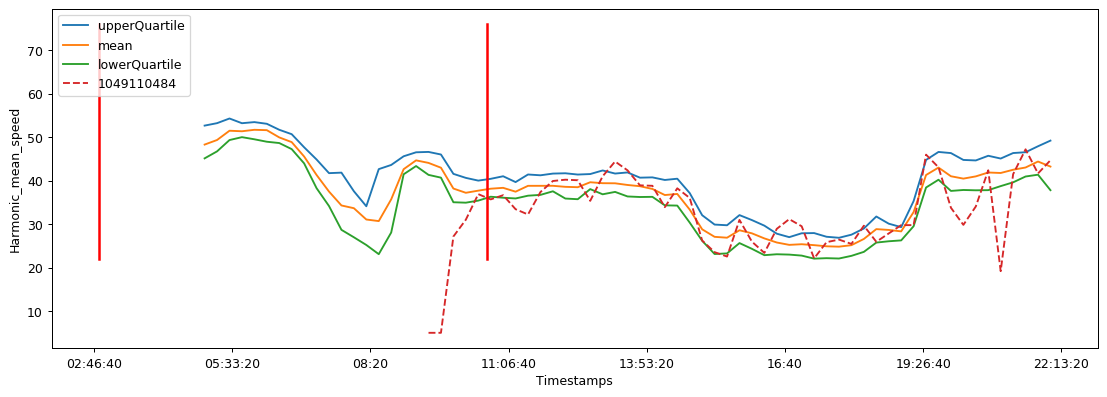

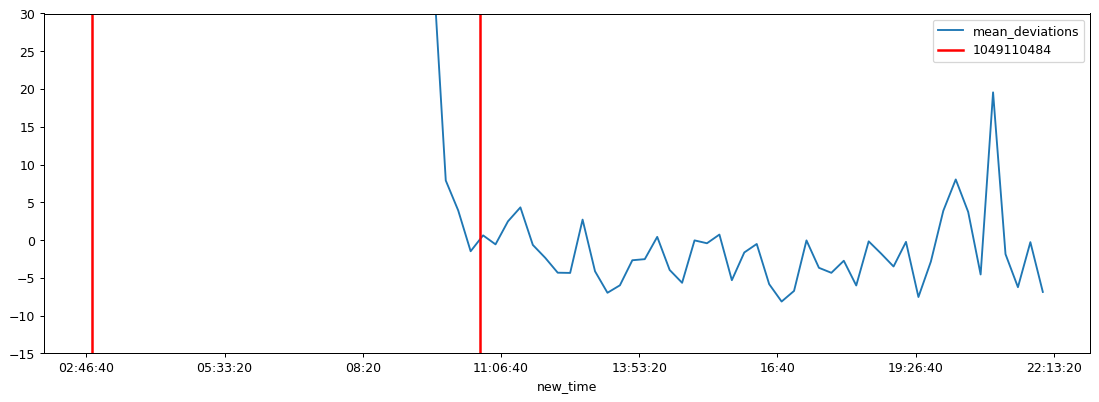

In [57]:
plot_speed(test_link)
plot_devation(test_link)

1049110484


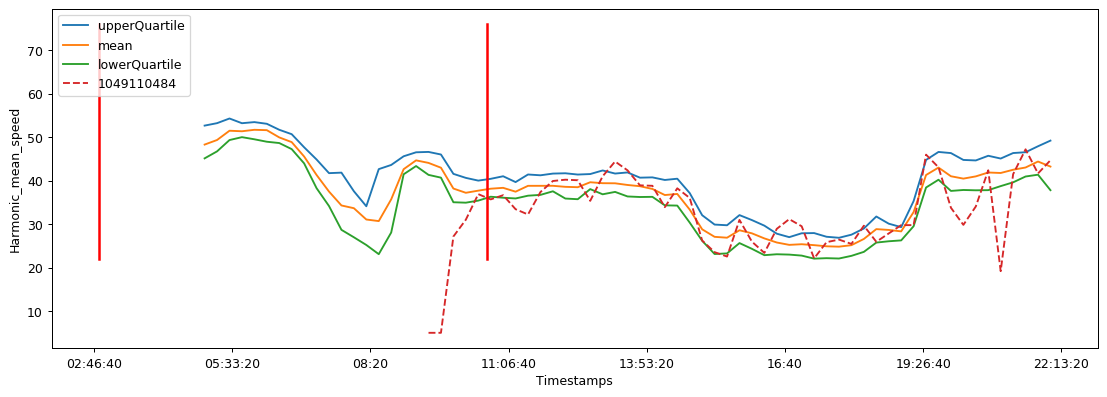

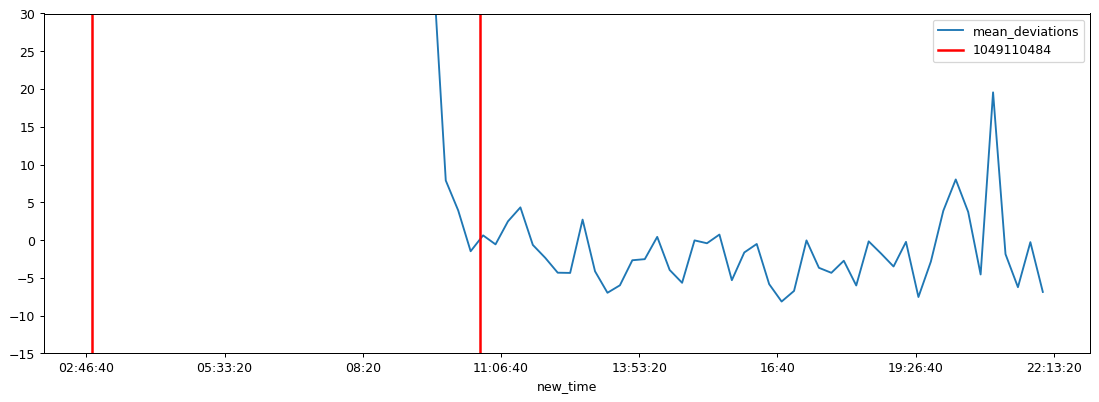

1048410491


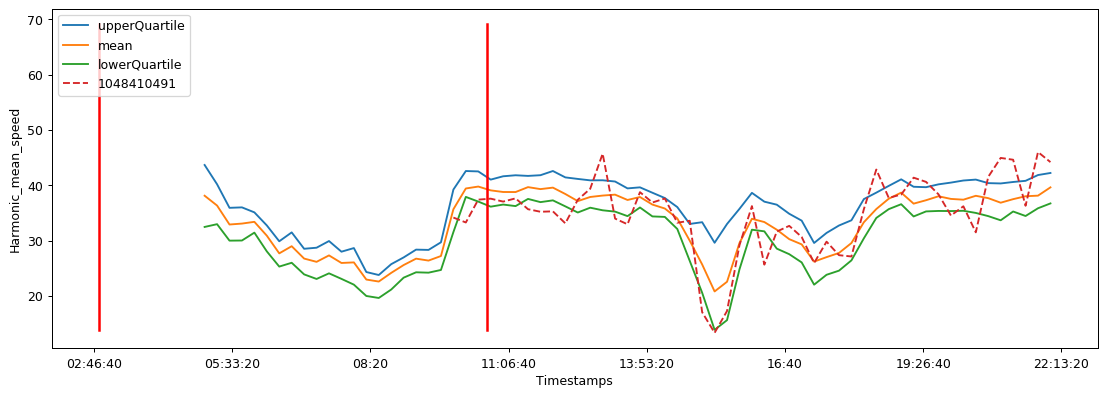

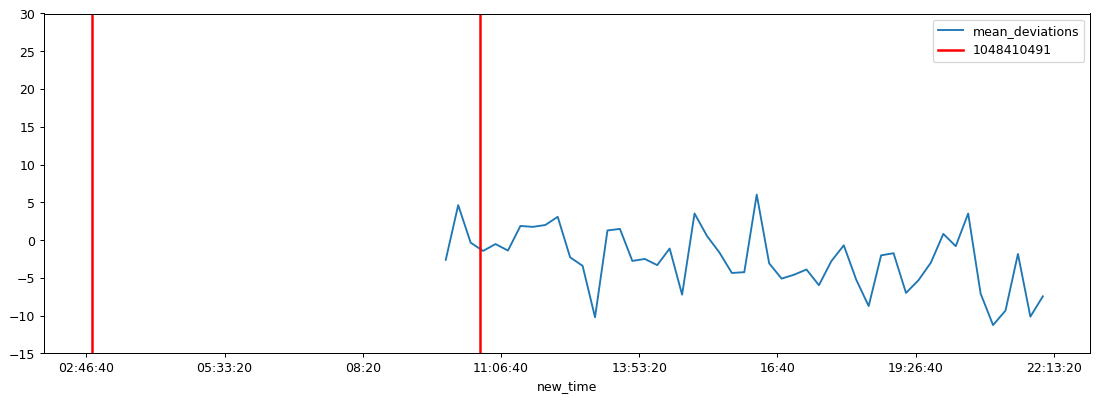

1048410494


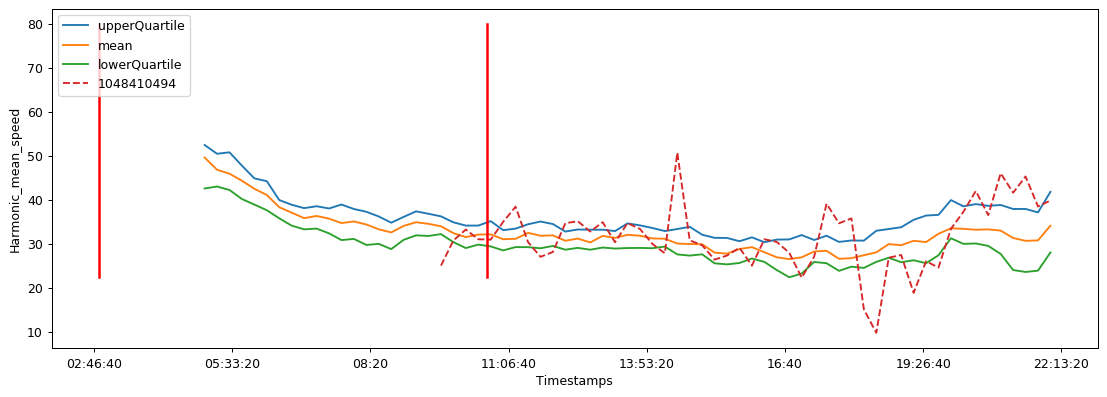

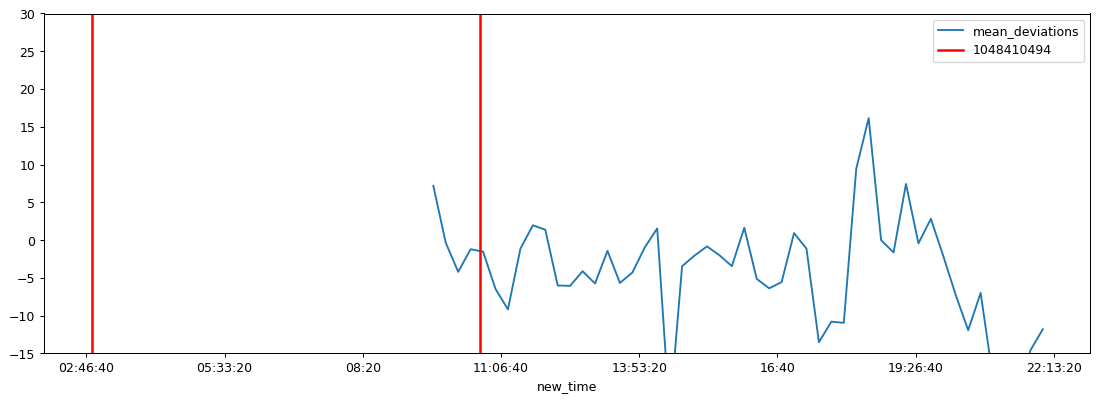

1048410538


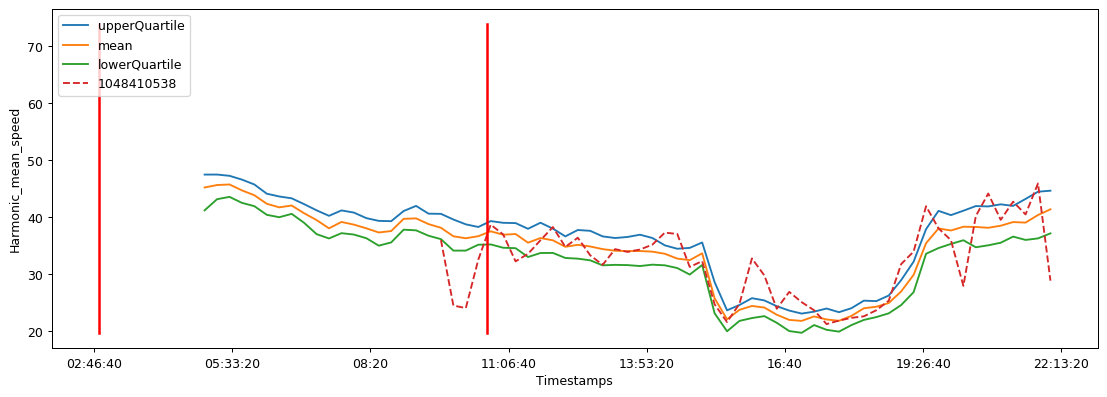

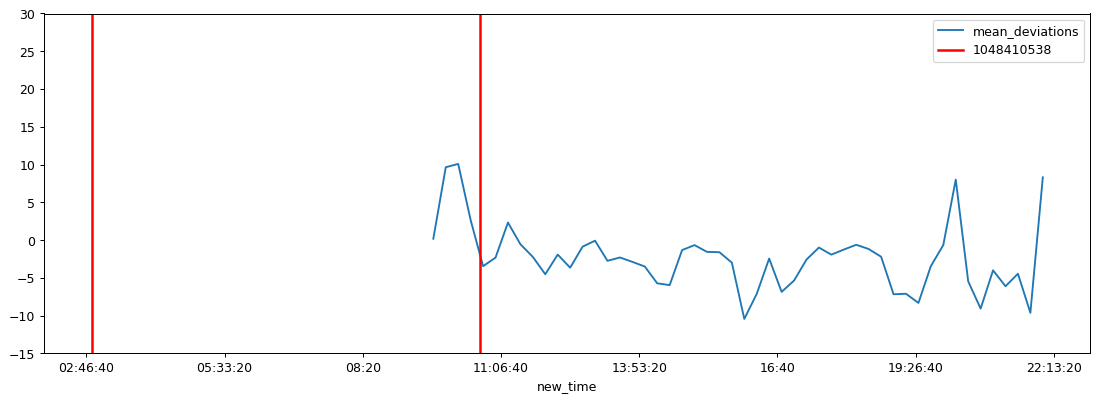

1048410576


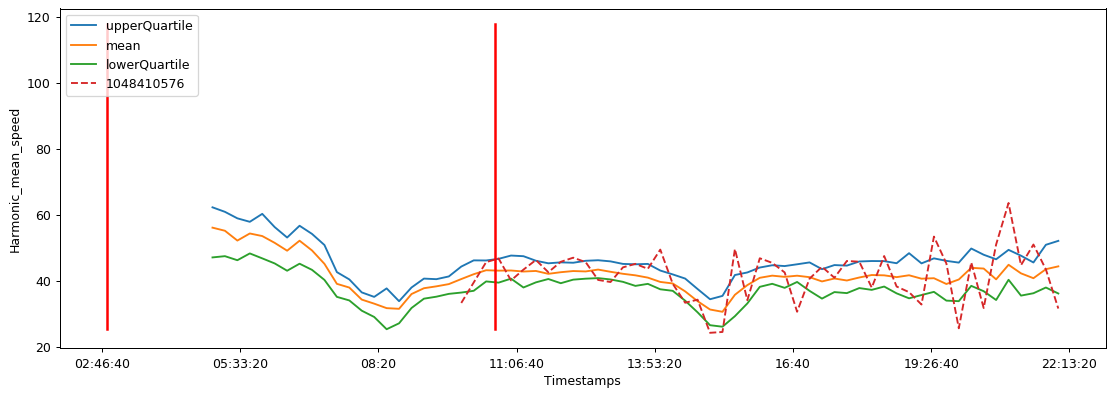

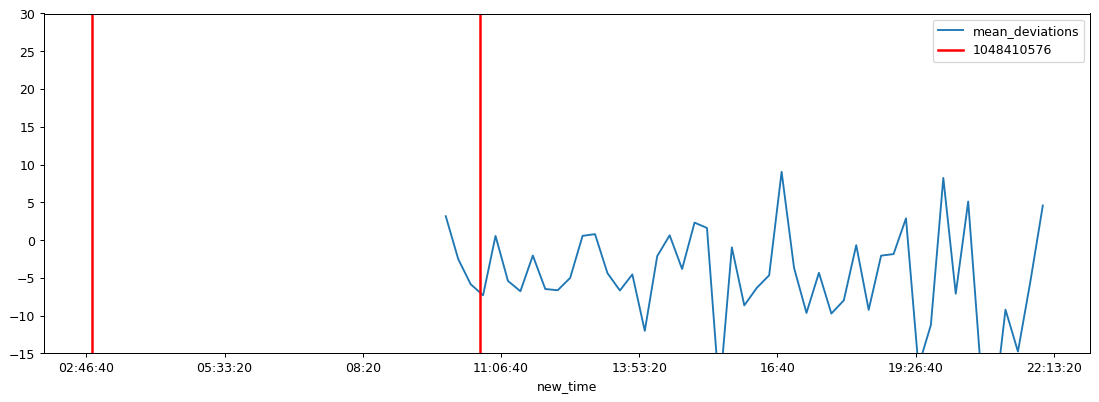

1049410484


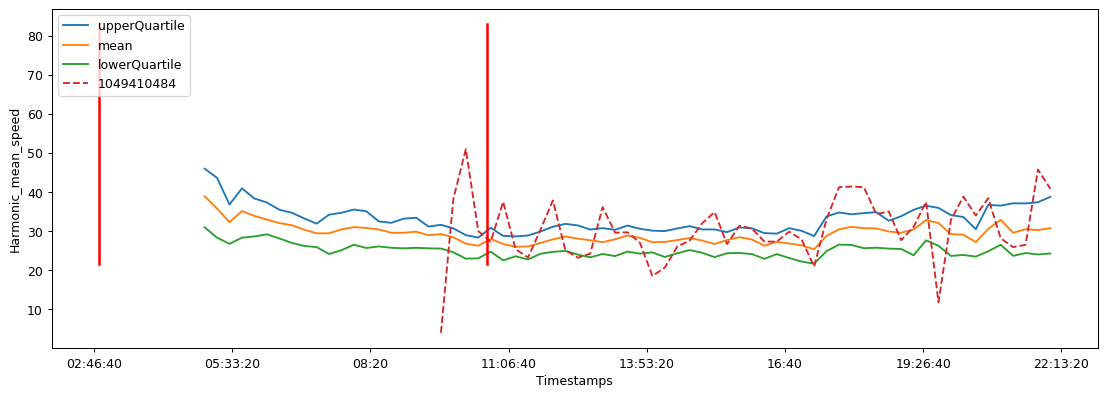

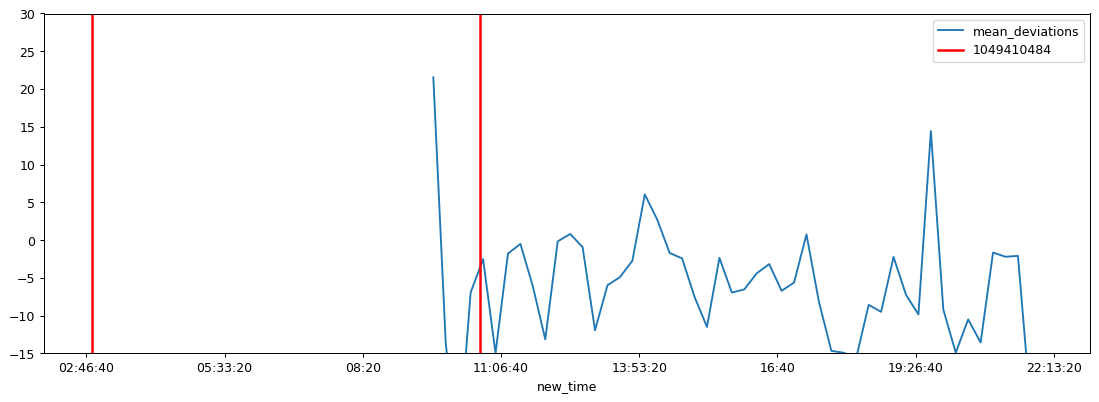

1053810484


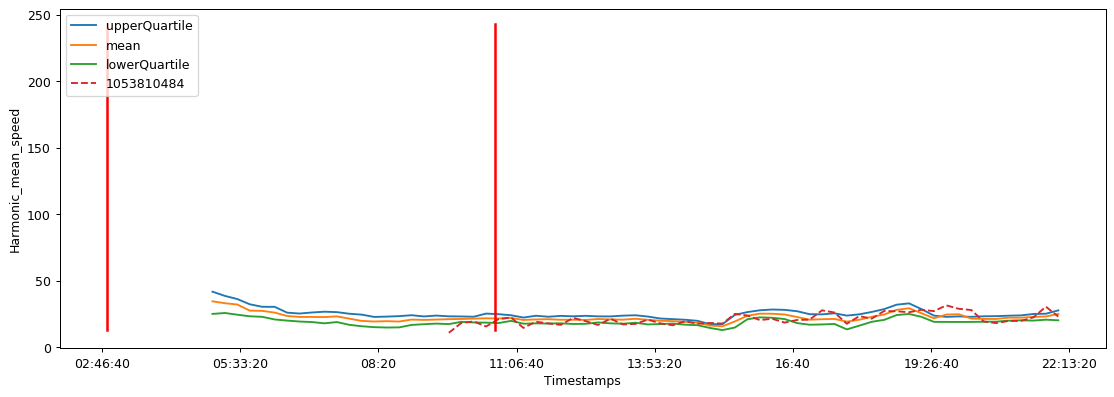

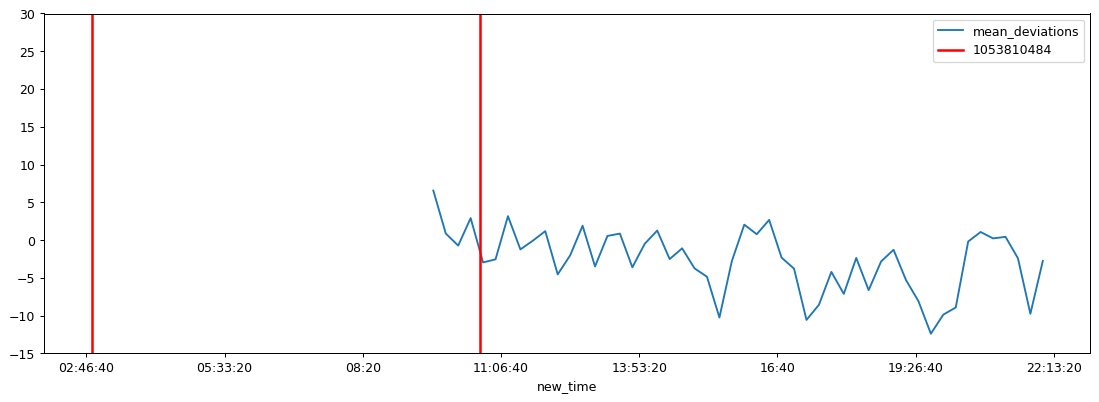

1057610484


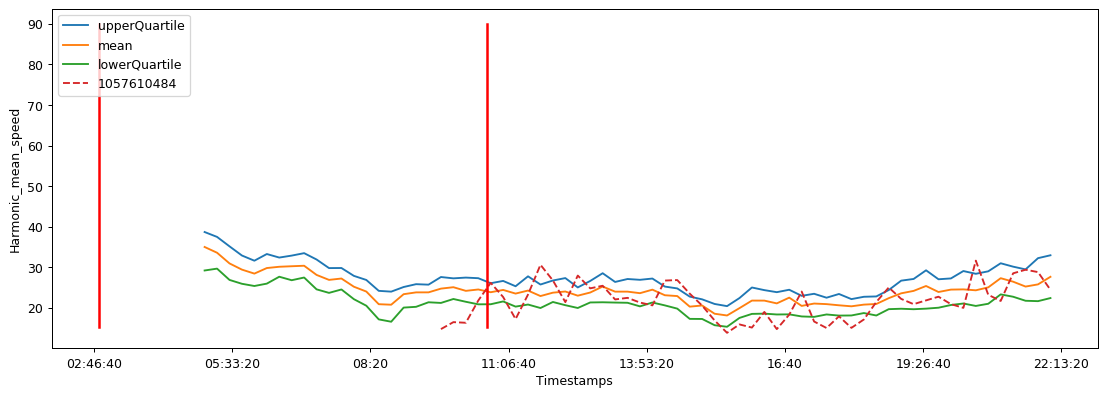

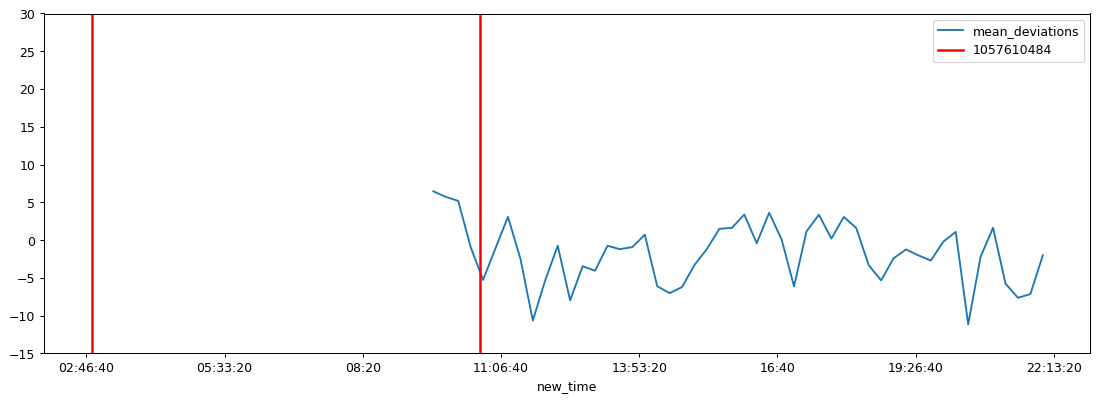

1071810491


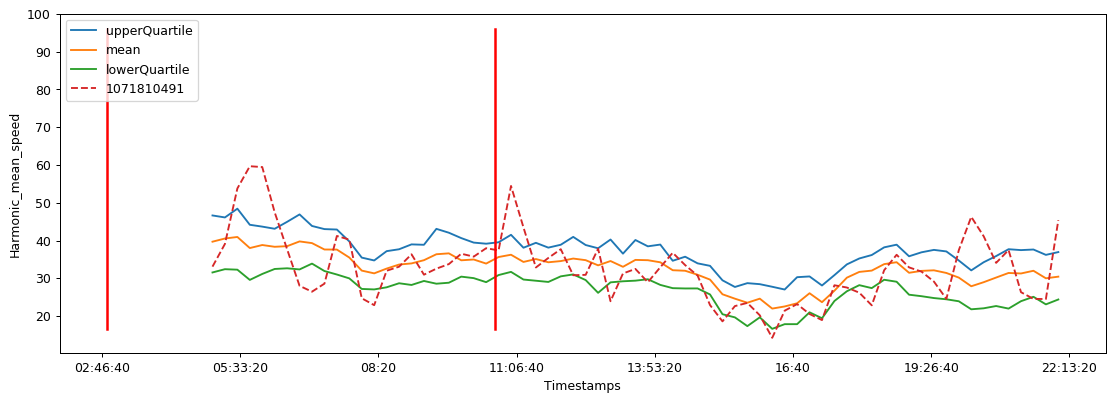

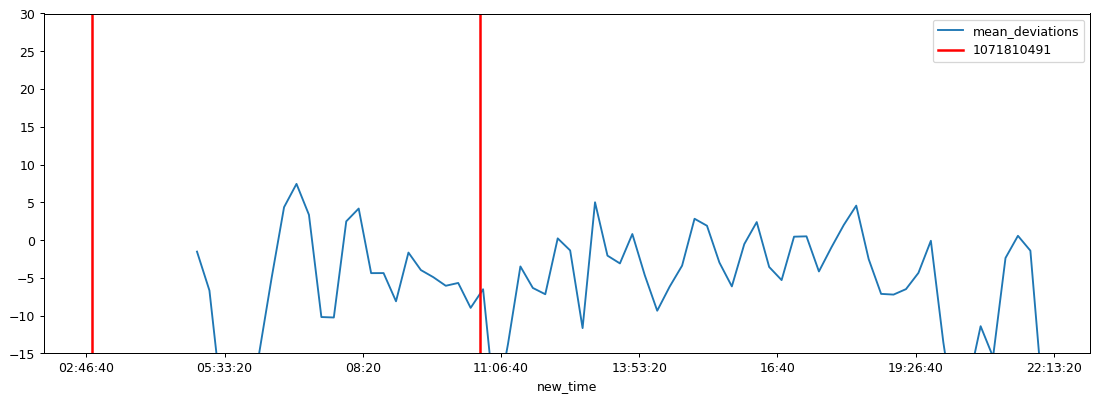

1044210491


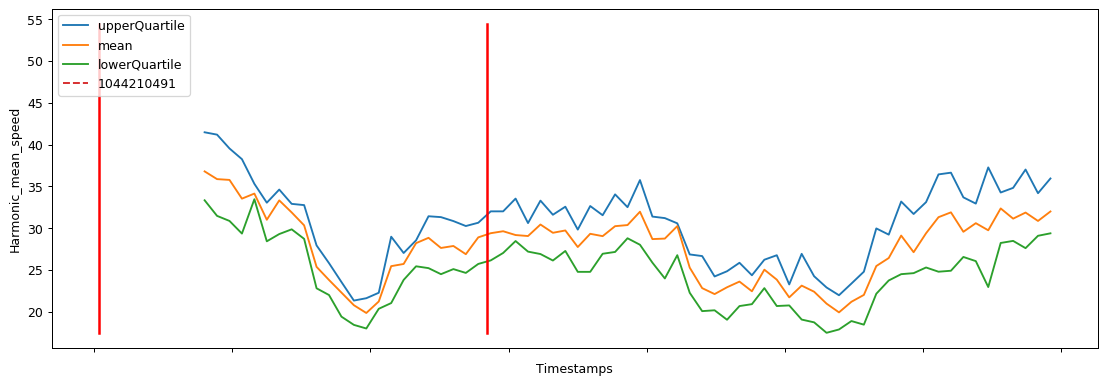

TypeError: float() argument must be a string or a number, not 'datetime.time'

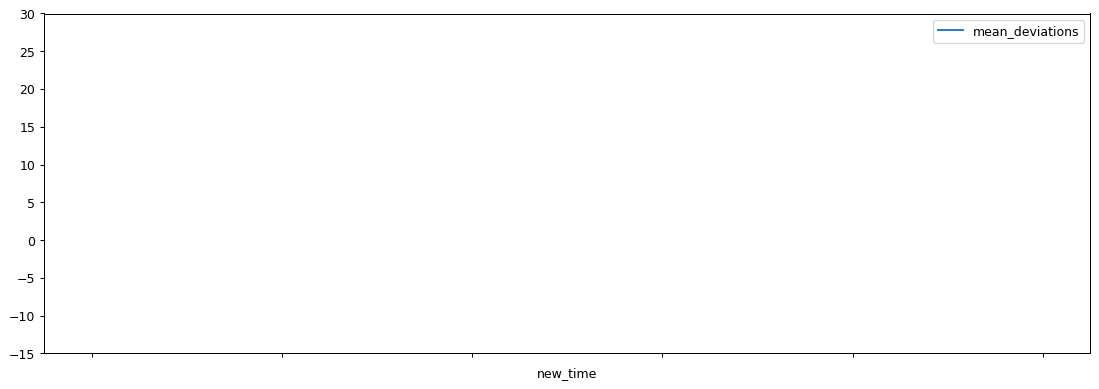

In [58]:
plot_all()